### Machine Learning Final Exam
* Mikkel Pedersen - S167541
* Mads Andersen - S167331
* Oliver Beck - S137486
* Benedicte Søvang Christiansen - S137322

##### Please Note: 
* The epoch is set to 1 prior to handin in order ensure all cells are running, set EPOCH=35 for reproduceabillity of the results in the handin.
* Pandas should be version >2.2, if you utilize conda for a package manager upgrade from terminal otherwise upgrade with code below: 

In [1]:
!pip3 install --upgrade pandas

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
#import tensorflow_hub as hub
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import random
import matplotlib.patches as patches
import os
from PIL import Image
import datetime
import numpy as np

# For loading from github
import requests
from io import StringIO
from PIL import Image
from io import BytesIO
import tqdm 

from sklearn.metrics import confusion_matrix,precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn import svm
from sklearn.metrics import multilabel_confusion_matrix

#For loading images in UClOUD: 
import zipfile
import os

In [3]:
seed = 42
tf.random.set_seed(seed)

### Hyper params 

In [4]:
IMG_SIZE = 224
CHANNELS = 3

BATCH_SIZE = 256 # Should according to litterature be large enough for F1 loss to take effect.
AUTOTUNE = tf.data.experimental.AUTOTUNE # Some tf optimizing stuff
SHUFFLE_BUFFER_SIZE = 512

LR = 5e-5
EPOCHS = 1 #35 #- Just set to 1 for 
weight_decay = 0.01

#Path to directory with data-set folder: 
extract_path = os.getcwd() # Insert this instead of specific path to accomedate differing paths

## EDA & pre-processing

### Get classes to concat

In [5]:
annotations_file = os.path.join(f'{extract_path}/Plastic pollution.v1i.tensorflow/train/_annotations.csv')
df = pd.read_csv(annotations_file)
df = df[['filename','class']].drop_duplicates()

In [6]:
freq = df['class'].value_counts().reset_index()
labels_2_concat = freq[freq['count'] <= 100]['class'].values

In [7]:
labels_2_concat

array(['Straws', 'Glass beverage bottle', 'Bottle- container Caps',
       'Face masks', 'Marine biomass', 'Can', 'Tyres', 'Foam fragments',
       'Personal care products', 'Soft food wrappers', 'Aerosol', 'Jars',
       'Utensils', 'Gloves', 'Cigarettes', 'Hard fragments',
       'Fragments_Glass', 'Fragments_Rubber', 'Fragments_Metal',
       'Soft fragments', 'Buoys - floats', 'Fishing'], dtype=object)

### Making a label mapping

In [8]:
def format_long_2_wide(df):
    return df.pivot_table(index='filename', columns = 'class', aggfunc = lambda x: 1).fillna(0).astype(int).reset_index()

def concat_classes(df):
    # Functionality for concatting classes: 
    agg_class = lambda x: x if x not in labels_2_concat else 'Other'
    df['class'] = df['class'].apply(agg_class)
    return df

In [9]:
df = concat_classes(df)
df = format_long_2_wide(df)
label_mapper = {idx:name for idx,name in enumerate(df.columns[1:])}

### Loading data-set for tensorflow

In [10]:
def load_dataset(data_dir,shuffle=False, shuffle_buffer_size=1000, return_as_pd = False):
    #Path load
    annotations_file = os.path.join(data_dir, '_annotations.csv')
    
    # read the annots
    df = pd.read_csv(annotations_file)
    df = df[['filename','class']].drop_duplicates()
    df = concat_classes(df)
    df = format_long_2_wide(df)

    #Return as pd, this is a concat of bennes and mads version of loading
    if return_as_pd:
        return df

    # Prepare image and label lists
    images = [os.path.join(data_dir, fname) for fname in df['filename']]
    labels = df.iloc[:,1:].to_numpy()

    # Load images and process them
    image_size = (224, 224)  # Adjust the size as needed
    path_ds = tf.data.Dataset.from_tensor_slices(images)
    image_ds = path_ds.map(lambda x: process_image(x, image_size))

    # Create a dataset of labels
    label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(labels, tf.int64))

    # Combine into a single dataset
    dataset = tf.data.Dataset.zip((image_ds, label_ds))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=shuffle_buffer_size)
    
    return dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

def process_image(file_path, image_size):
    # Read the file
    img = tf.io.read_file(file_path)
    # Decode the image file
    img = tf.image.decode_jpeg(img, channels=3)
    # Resize the image
    img = tf.image.resize(img, image_size)
    # Normalize the image
    return img / 255.0

# Paths to train, validation, and test datasets
train_dir = os.path.join(f'{extract_path}/Plastic pollution.v1i.tensorflow', 'train')
val_dir = os.path.join(f'{extract_path}/Plastic pollution.v1i.tensorflow', 'val')
test_dir = os.path.join(f'{extract_path}/Plastic pollution.v1i.tensorflow', 'test')

#Get as dfs 
train_df = load_dataset(train_dir, return_as_pd = True)
val_df = load_dataset(val_dir,return_as_pd = True)
test_df = load_dataset(test_dir, return_as_pd = True)

#For tensor flow
train_ds = load_dataset(train_dir,shuffle = True)
val_ds = load_dataset(val_dir)
test_ds = load_dataset(test_dir)

### Class imbalance plot: 

/var/folders/cc/rt79l3cs2y5_4qjk70l_189w0000gn/T/ipykernel_54003/3258277683.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


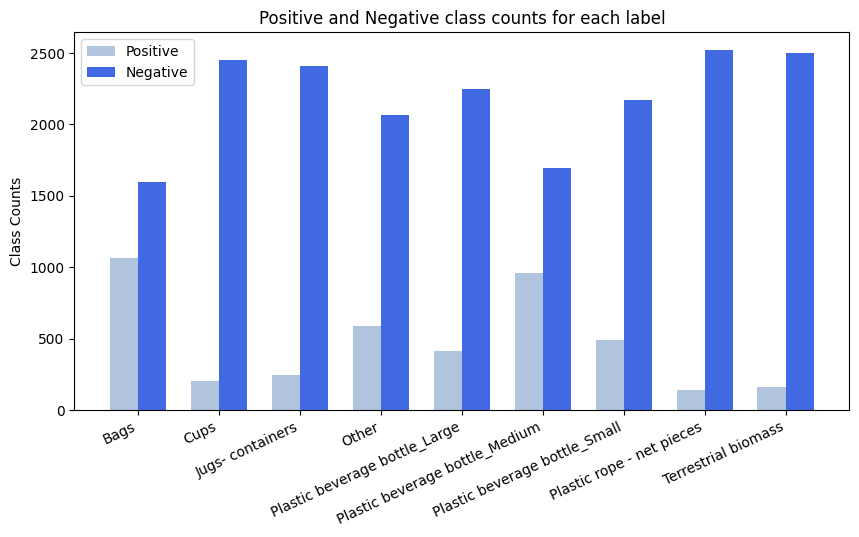

In [11]:
def class_imbalance_plot(df):
    pos_counts = df.iloc[:, 1:].sum()
    neg_counts = df.iloc[:, 1:].apply(lambda x: len(x) - x.sum())
    
    counts = pd.DataFrame({
        'Class': df.columns[1:],
        'Positive': pos_counts.values,
        'Negative': neg_counts.values
    })
    
    fig, ax = plt.subplots(figsize=(10, 6))
    index = pd.Index(range(len(counts['Class'])))
    
    bar_width = 0.35
    rects1 = ax.bar(index - bar_width/2, counts['Positive'], bar_width, label='Positive', color = 'lightsteelblue')
    rects2 = ax.bar(index + bar_width/2, counts['Negative'], bar_width, label='Negative', color = 'royalblue')
    
    ax.set_ylabel('Class Counts')
    ax.set_title('Positive and Negative class counts for each label')
    ax.set_xticks(index)
    ax.set_xticklabels(counts['Class'])
    ax.legend()
    plt.xticks(rotation=25,ha='right')
    plt.subplots_adjust(bottom=0.25) 
    return fig

fig = class_imbalance_plot(train_df)
fig.show()

/var/folders/cc/rt79l3cs2y5_4qjk70l_189w0000gn/T/ipykernel_54003/3917137789.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  class_imbalance_plot(val_df).show()


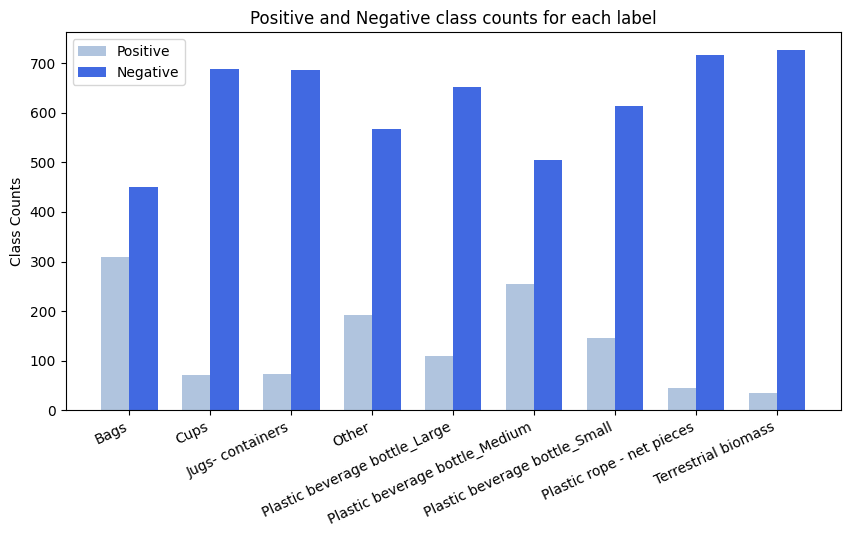

In [12]:
class_imbalance_plot(val_df).show()

/var/folders/cc/rt79l3cs2y5_4qjk70l_189w0000gn/T/ipykernel_54003/2216599884.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  class_imbalance_plot(test_df).show()


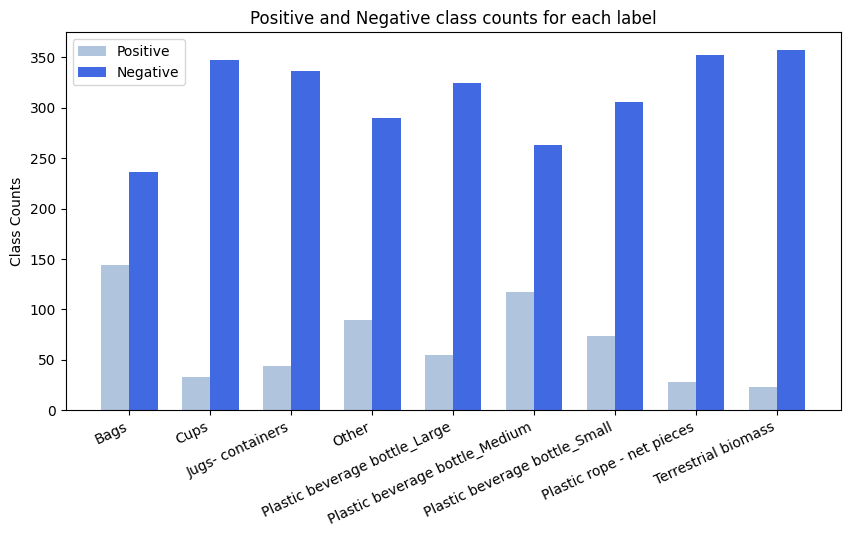

In [13]:
class_imbalance_plot(test_df).show()

## Co-Occurence matrix

In [14]:
labels = train_df.iloc[:,1:].to_numpy()
co_occurrence_matrix = labels.T.dot(labels)

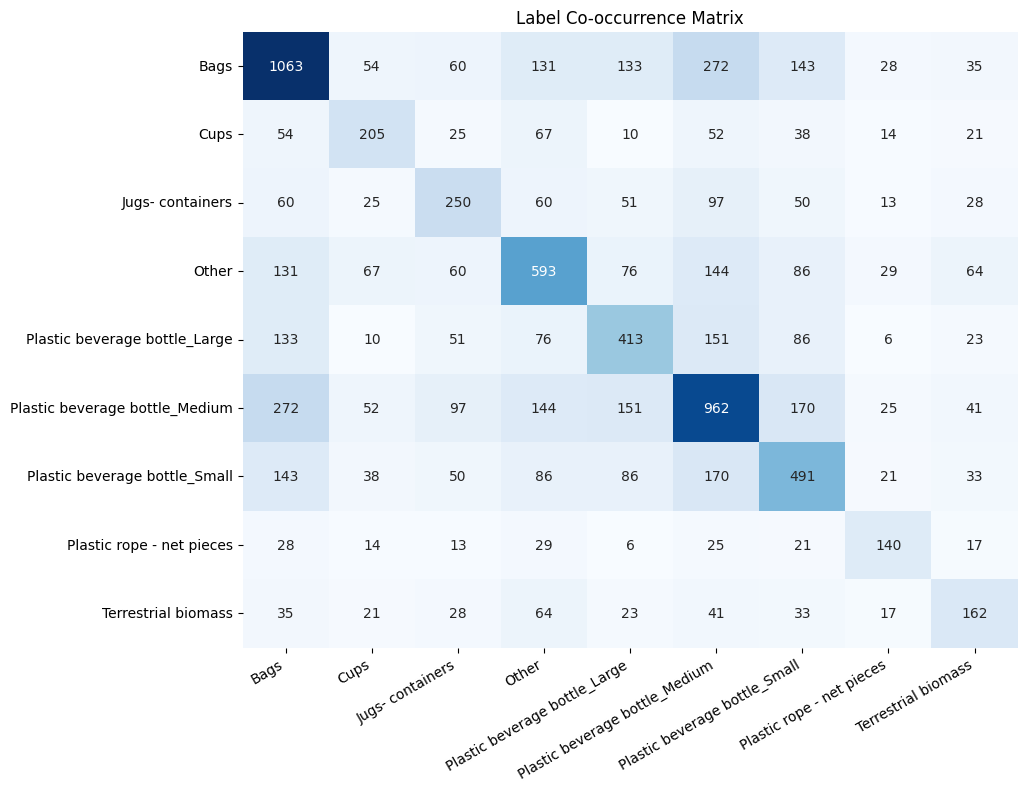

In [15]:
# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(co_occurrence_matrix,
            annot=True,
            fmt='d',
            cmap='Blues',
            cbar = False,
            xticklabels=train_df.columns[1:],
            yticklabels=train_df.columns[1:])
plt.title('Label Co-occurrence Matrix')
plt.xticks(rotation=30,ha='right')
plt.show()

### Class frequencies 

In [16]:
# Get the processed df 
# Get the original prior to processing: 
df = pd.read_csv(train_dir+'/_annotations.csv')
df = df[['filename','class']].drop_duplicates()
df = concat_classes(df)

In [17]:
# Get the original prior to processing: 
df1 = pd.read_csv(train_dir+'/_annotations.csv')
df1 = df1[['filename','class']].drop_duplicates()

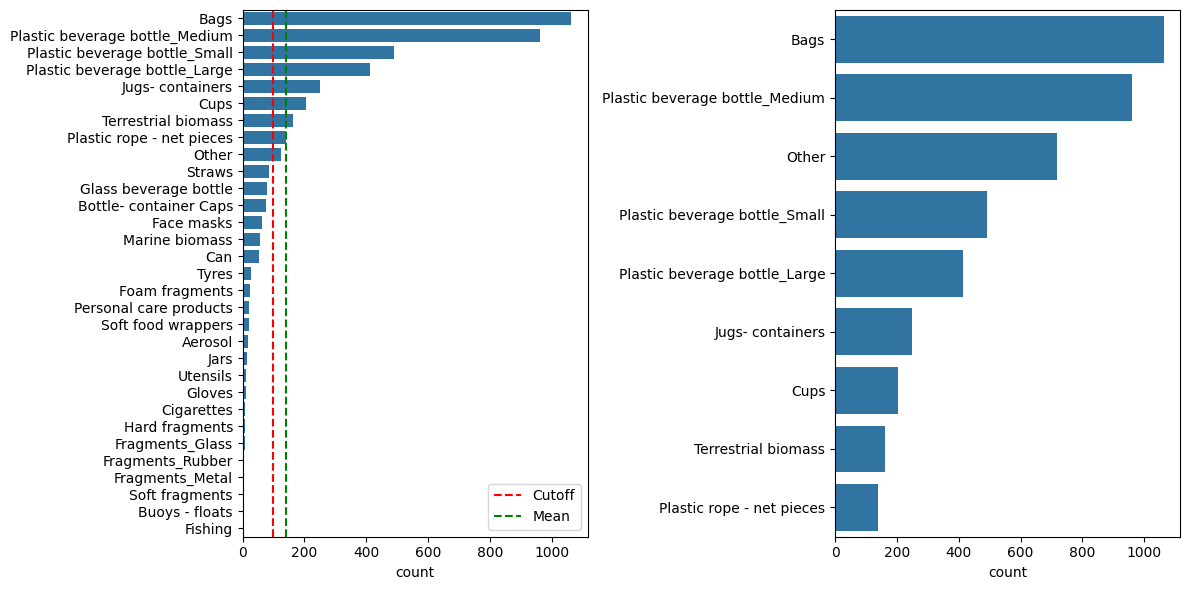

In [18]:
freq1 = df1['class'].value_counts()
freq = df['class'].value_counts()

fig,ax = plt.subplots(1,2,figsize = (12,6))
sns.barplot(data = freq1, orient='h', ax = ax[0])
ax[0].axvline(x=100, color = 'red', linestyle = '--',label ='Cutoff')
ax[0].axvline(x=freq1.mean(), color = 'green', linestyle = '--', label ='Mean')
ax[0].set(ylabel=None)

#after freq plot
sns.barplot(data = freq, orient='h', ax = ax[1])
ax[1].set(ylabel=None)

ax[0].legend()
plt.tight_layout()

### Get size of the cross validation splits

In [19]:
2659/sum([2659, 760, 380]),760/sum([2659, 760, 380]),380/sum([2659, 760, 380])

(0.6999210318504869, 0.20005264543300869, 0.10002632271650434)

#### Display some augmentations 

In [20]:
augs = {'Flipping': keras.layers.RandomFlip("horizontal_and_vertical"),
        'Translation': keras.layers.RandomTranslation(height_factor=(-0.2, 0.3),width_factor=(-0.2, 0.3)),
        'Rotations': keras.layers.RandomRotation(0.2)}

In [21]:
augmented = {}
for X,y in train_ds:
    print(X.shape)
    augmented['Flipping'] = augs['Flipping'](X)[:9]
    augmented['Translation'] = augs['Translation'](X)[:9]
    augmented['Rotations'] = augs['Rotations'](X)[:9]
    break

(256, 224, 224, 3)


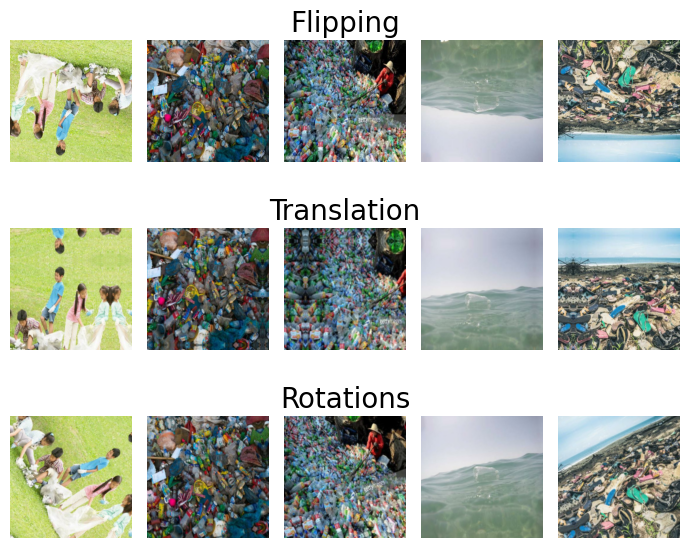

In [22]:
fig, axs = plt.subplots(3,5, figsize=(7,6))

for idx,row in enumerate(axs):
  aug_name = list(augmented.keys())[idx]
  for jdx,ax in enumerate(row):
    ax.imshow(augmented[aug_name][jdx])
    if jdx == 2:
      ax.set_title(aug_name,fontsize=20)
    ax.axis('off')

plt.tight_layout()

### Custom losses, these are not ours all credits attributed to:
#### https://github.com/gabriben/metrics-as-losses/tree/main
We had trouble creating a stable build for their package so we copy paste the functions needed directly from the github repo of the package.

In [23]:
@tf.function
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.

    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)

    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis = 0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis = 0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis = 0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

@tf.function
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)

    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive

    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y = tf.cast(y, tf.float32)
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

# Hyper params for sigmoid function
S = -10 # sigmoid s-shape hyperparam
E = 1 # sigmoid offset hyperparam

@tf.function
def sigmoidF1(y, y_hat, from_logits = False):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    
    if from_logits == True:
        # y = tf.nn.softmax(y)
        #y_hat = tf.nn.softmax(y_hat)
        y_hat = tf.math.sigmoid(y_hat)
        #y_hat = tf.math.exp(y_hat) / (tf.math.exp(y_hat) + 1)
        
    b = tf.constant(S, tf.float32)
    c = tf.constant(E, tf.float32)
    sig = 1 / (1 + tf.math.exp(b * (y_hat + c)))
    tp = tf.reduce_sum(sig * y, axis=0)
    fp = tf.reduce_sum(sig * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - sig) * y, axis=0)

    sigmoid_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - sigmoid_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macroCost = tf.reduce_mean(cost) # average on all labels
    return macroCost

### Model training
First build the model with the function and the sequential api 

In [24]:
def create_model():
    base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                                        include_top=False,
                                                        weights='imagenet',
                                                        pooling = 'avg')
    base_model.trainable = False
    augmentations = tf.keras.Sequential([keras.layers.RandomFlip("horizontal_and_vertical"),
                                         keras.layers.RandomTranslation(height_factor=(-0.2, 0.3),width_factor=(-0.2, 0.3)),
                                         keras.layers.RandomRotation(0.2)
                                            ])

    # Add linear classifier to feature extractor : 
    model = models.Sequential([
        augmentations,
        base_model, 
        layers.Dense(128, activation='relu'),
        layers.Dense(9, activation='sigmoid')
    ])
    #Compile model
    model.compile(
                  optimizer=tf.keras.optimizers.Adam(learning_rate=LR,weight_decay = weight_decay),
                  loss = sigmoidF1,#macro_soft_f1,#'binary_crossentropy',#sigmoidF1,
                  metrics=[macro_f1])


    return model

In [25]:
model = create_model()
model.build()

In [26]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

### Inspect model training with the tensorboard

In [27]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

In [28]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [29]:
callback = keras.callbacks.EarlyStopping(monitor='loss',
                                         patience=4)
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds,
                    callbacks = [callback, tensorboard_callback])

11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 0.7122 - macro_f1: 0.1870 - val_loss: 0.7118 - val_macro_f1: 0.2023


### Testing

In [30]:
# Load weights for inference after some training we comment it out such that if they don't have the trained model, they cant load it ofc
#model.load_weights('MobileNetV2Finetuning.keras')

In [31]:
y_val = val_df.iloc[:,1:].to_numpy()
y_test = test_df.iloc[:,1:].to_numpy()

In [32]:
y_test.shape,y_val.shape

((380, 9), (760, 9))

In [33]:
preds_val = model.predict(val_ds)
preds_test = model.predict(test_ds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 642ms/step


In [34]:
def get_opt_th(y_test,y_pred):
  """
  This function will expect that y_test and y_preds are binary classification examples,
  that means that they should each represent a column from the predicted labels
  """
  precision, recall, thresholds = precision_recall_curve(y_test,y_pred)
  f1s = (2*precision*recall)/(precision+recall+1e-16)
  return thresholds[f1s.argmax()],f1s.max() # Return max index

def get_multi_label_cm(y_test,preds,ths):
  cms = {}
  for i in range(y_test.shape[1]):
    th = ths[i]
    cm = confusion_matrix(y_test[:,i],preds[:,i]>th)
    prec = cm[1,1]/(cm[1,1]+cm[0,1])
    recall = cm[1,1]/(cm[1,1]+cm[1,0])
    f1 = 2*prec*recall/(prec+recall)
    cms[label_mapper[i]] = [cm,f1]
  return cms

In [35]:
ths = [get_opt_th(y_val[:,i],preds_val[:,i])[0] for i in range(9)]

In [36]:
ths

[0.04797365,
 0.7160962,
 0.5962357,
 0.3249255,
 0.19259419,
 0.1076715,
 0.12369566,
 0.20276502,
 0.50752103]

In [37]:
total_cm = sum([x[0] for x in get_multi_label_cm(y_val,preds_val,ths).values()])

In [38]:
avg_precission = total_cm[1,1]/(total_cm[0,1]+total_cm[1,1])
avg_recall = total_cm[1,1]/(total_cm[1,0]+total_cm[1,1])
macro_f1_meas = total_cm[1,1]/(total_cm[1,1]+0.5*(total_cm[0,1]+total_cm[1,0]))
s = f'avg. prec: {avg_precission: .2f}\navg. recall: {avg_recall: .2f}\nMacro F1: {macro_f1_meas: .2f}'
print(s)

avg. prec:  0.21
avg. recall:  0.88
Macro F1:  0.35


### Plot Prec-recall curve

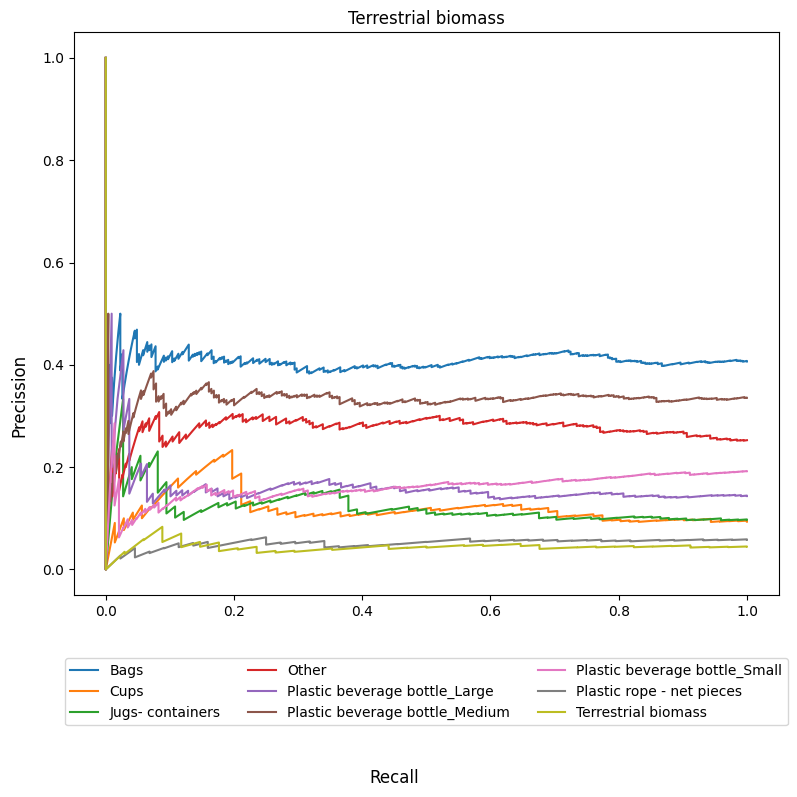

In [39]:
fig, ax = plt.subplots(1,1, figsize = (8,8))
#ax = ax.ravel()
for i in range(y_val.shape[1]):
    y = y_val[:,i]
    y_hat = preds_val[:,i]
    precision, recall, thresholds = precision_recall_curve(y,y_hat)
    ax.plot(recall,precision, label = label_mapper[i])
    ax.set_title(label_mapper[i])
    fig.supylabel('Precission')
    fig.supxlabel('Recall')
    plt.tight_layout()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.subplots_adjust(bottom=0.25) 

## Get the confusion matrices

In [40]:
def disp_conf_mats(y_test,preds,ths):
  cms = get_multi_label_cm(y_test,preds,ths)
  fig, axs = plt.subplots(3,3, figsize = (8,9),sharey=True,sharex=True)

  for (name, cm), ax in zip(cms.items(),axs.ravel()):
    sns.heatmap(cm[0],annot = True, fmt = '.0f', cbar = False, ax = ax,cmap='crest')
    ax.set_title(f'{name}\nF1:{round(cm[1],2)}', fontsize = 11)

  fig.supylabel('True Label')
  fig.supxlabel('Predictions')
  plt.tight_layout()
  fig.show()
  return fig

/var/folders/cc/rt79l3cs2y5_4qjk70l_189w0000gn/T/ipykernel_54003/2180065084.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/cc/rt79l3cs2y5_4qjk70l_189w0000gn/T/ipykernel_54003/1542728833.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  disp_conf_mats(y_test,preds_test,ths).show()


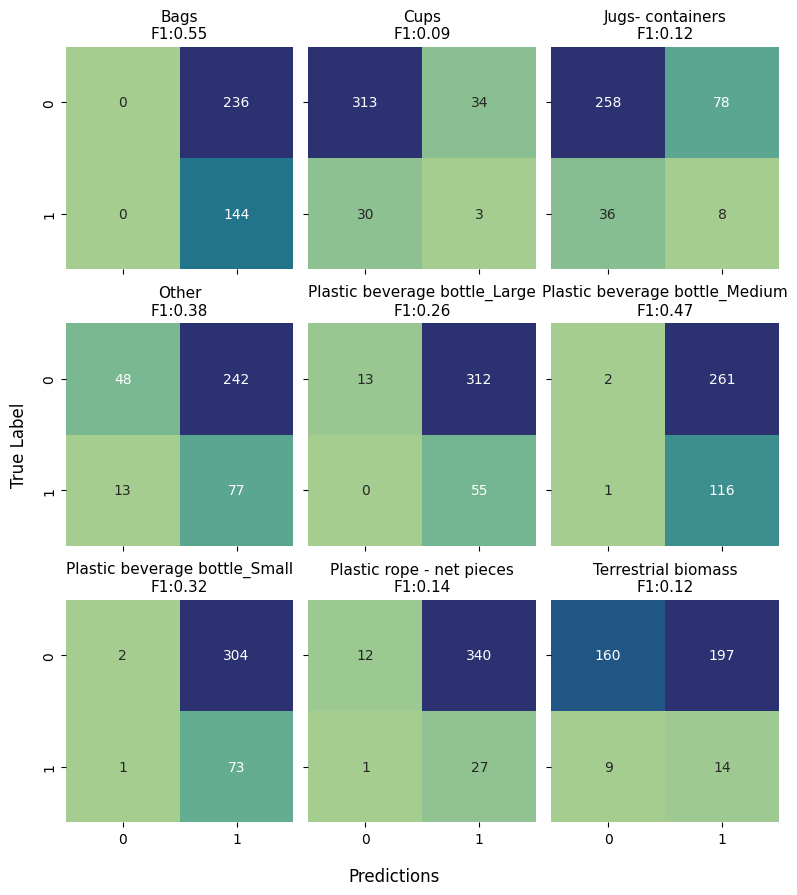

In [41]:
disp_conf_mats(y_test,preds_test,ths).show()

### Loss diagnosis - can also just be seen in tensorboard

In [42]:
loss = history.history['loss']
val_loss = history.history['val_loss']

<Axes: >

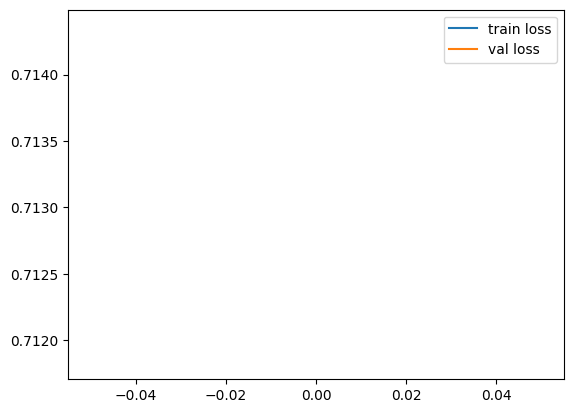

In [43]:
fig, ax = plt.subplots(1,1)
sns.lineplot(loss,label = 'train loss', ax = ax)
sns.lineplot(val_loss, label = 'val loss', ax = ax)

### SVM multi label 
We utilize specialized svm models to create binary classifications for each class. 
** Be aware that the svm can be quite memory heavy **
  

In [44]:
def dataset_to_numpy(dataset):
    X, y = [], []
    for images, labels in dataset:
        X.append(images.numpy())
        y.append(labels.numpy())
        
    X = np.concatenate(X, axis=0)
    y = np.concatenate(y, axis=0)
    return X, y

# We just utilize the prior dataset might be inefficient tho
X_train, y_train = dataset_to_numpy(train_ds)
X_val, y_val = dataset_to_numpy(val_ds)
X_test, y_test = dataset_to_numpy(test_ds)

2024-05-16 18:41:10.013820: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-16 18:41:10.418016: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-16 18:41:10.566219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [45]:
X_train.shape, y_train.shape

((2659, 224, 224, 3), (2659, 9))

#### Flatten the images

In [46]:
# Flatten them all since know we wount be using convs 
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [47]:
pipeline = Pipeline([
                    ('scaler', StandardScaler()),  
                    ('pca', PCA(n_components=0.85)),
                    ('clf', MultiOutputClassifier(svm.SVC(class_weight = 'balanced')))  # This is found from docs of sklearn
                    ],
                    verbose=True)

In [48]:
pipeline.fit(X_train_flat, y_train)

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   3.1s
[Pipeline] ............... (step 2 of 3) Processing pca, total= 1.4min
[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.0s


Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.85)),
                ('clf',
                 MultiOutputClassifier(estimator=SVC(class_weight='balanced')))],
         verbose=True)

In [49]:
preds = pipeline.predict(X_test_flat)

In [50]:
total_cm = sum(multilabel_confusion_matrix(y_test,preds))

In [51]:
avg_precission = total_cm[1,1]/(total_cm[0,1]+total_cm[1,1])
avg_recall = total_cm[1,1]/(total_cm[1,0]+total_cm[1,1])
macro_f1_meas = total_cm[1,1]/(total_cm[1,1]+0.5*(total_cm[0,1]+total_cm[1,0]))
s = f'avg. prec: {avg_precission: .2f}\navg. recall: {avg_recall: .2f}\nMacro F1: {macro_f1_meas: .2f}'
print(s)

avg. prec:  0.33
avg. recall:  0.48
Macro F1:  0.39


#### Display the confusion matrices for the appendix

/var/folders/cc/rt79l3cs2y5_4qjk70l_189w0000gn/T/ipykernel_54003/2495764798.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


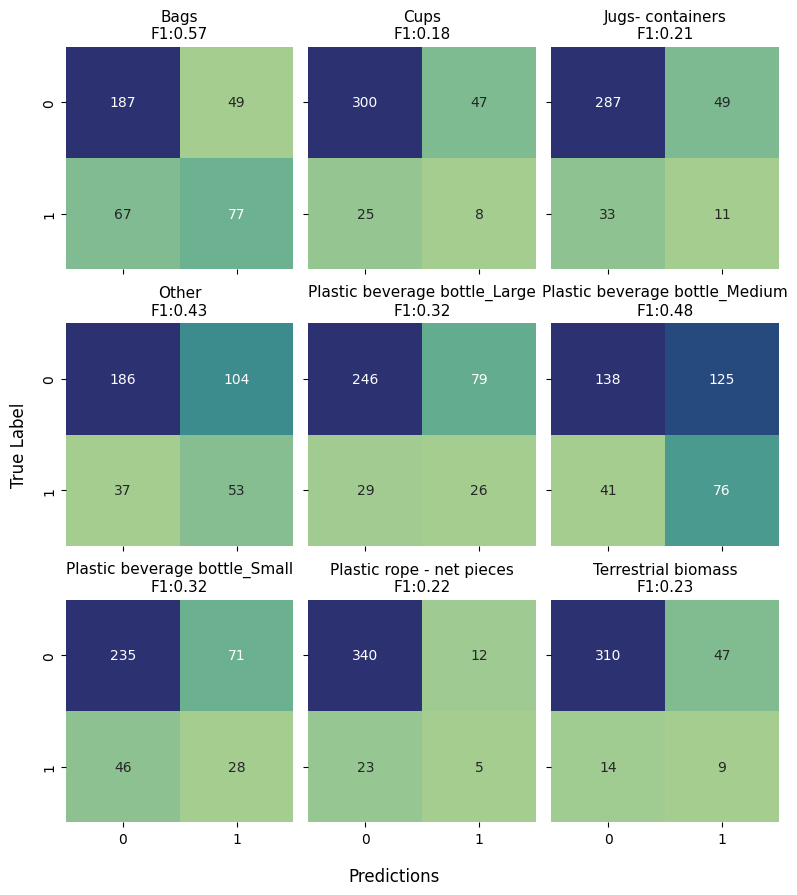

In [52]:
fig, axs = plt.subplots(3,3, figsize = (8,9),sharey=True,sharex=True)
cms = multilabel_confusion_matrix(y_test,preds)

for idx ,(cm, ax) in enumerate(zip(cms,axs.ravel())):
  f1_macro = cm[1,1]/(cm[1,1]+0.5*(cm[0,1]+cm[1,0]))
  sns.heatmap(cm,annot = True, fmt = '.0f', cbar = False, ax = ax,cmap='crest')
  ax.set_title(f'{label_mapper[idx]}\nF1:{round(f1_macro,2)}',fontsize = 11)

fig.supylabel('True Label')
fig.supxlabel('Predictions')
plt.tight_layout()
fig.show()